# Notebook for reformatting multimodal datasets (RNA+ATAC) 

We use RNA/GEX interchangeably. (We will call ATAC as just ATAC).

This is very similar to RNA+ADT notebook in terms of the fact that the cells are shared between the two modalities. We just need to be careful with the following
- (1) cell_id being consistent when merging
- (2) each modalities are normalized separately
- (3) keeping the embeddings from both modalities.

## Note that this object is already concatenated with multiple donors, as well as the count matrix already has the form of cell x (RNA+ATAC) format.

What we will do:
- subset for only one site/donor (s1d1)
- rename the var with each modality (either RNA or ATAC)
- redo the log-normalization for each modality, then merge (this is pretty much for visualization only)

In [1]:
import numpy as np
import scanpy as sc
import anndata as ad
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import tqdm
import sys
import os
from scipy import sparse

In [2]:
adata = sc.read_h5ad("/mnt/ibm_lg/yangjoon.kim/excellxgene_tutorial_manuscript/data/neurips2021_multiome/multiome_BMMC_processed.h5ad")
adata

AnnData object with n_obs × n_vars = 69249 × 129921
    obs: 'GEX_pct_counts_mt', 'GEX_n_counts', 'GEX_n_genes', 'GEX_size_factors', 'GEX_phase', 'ATAC_nCount_peaks', 'ATAC_atac_fragments', 'ATAC_reads_in_peaks_frac', 'ATAC_blacklist_fraction', 'ATAC_nucleosome_signal', 'cell_type', 'batch', 'ATAC_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker'
    var: 'feature_types', 'gene_id'
    uns: 'ATAC_gene_activity_var_names', 'dataset_id', 'genome', 'organism'
    obsm: 'ATAC_gene_activity', 'ATAC_lsi_full', 'ATAC_lsi_red', 'ATAC_umap', 'GEX_X_pca', 'GEX_X_umap'
    layers: 'counts'

In [5]:
adata.obs.Samplename

TAGTTGTCACCCTCAC-1-s1d1     site1_donor1_multiome
CTATGGCCATAACGGG-1-s1d1     site1_donor1_multiome
CCGCACACAGGTTAAA-1-s1d1     site1_donor1_multiome
TCATTTGGTAATGGAA-1-s1d1     site1_donor1_multiome
ACCACATAGGTGTCCA-1-s1d1     site1_donor1_multiome
                                    ...          
AAACCGCGTTTGAGGC-12-s4d9    site4_donor9_multiome
TGACTTAAGTTCCCGT-12-s4d9    site4_donor9_multiome
GCTGTACCACCGTTCC-12-s4d9    site4_donor9_multiome
ACACTTGCAACTAGAA-12-s4d9    site4_donor9_multiome
CACTTAAAGTCTGGGC-12-s4d9    site4_donor9_multiome
Name: Samplename, Length: 69249, dtype: category
Categories (13, object): ['site1_donor1_multiome', 'site1_donor2_multiome', 'site1_donor3_multiome', 'site2_donor1_multiome', ..., 'site3_donor10_multiome', 'site4_donor1_multiome', 'site4_donor8_multiome', 'site4_donor9_multiome']

In [7]:
# subset the anndata for s1d1 (site1 donor1)
adata = adata[adata.obs.Samplename=="site1_donor1_multiome"]
adata

View of AnnData object with n_obs × n_vars = 6224 × 129921
    obs: 'GEX_pct_counts_mt', 'GEX_n_counts', 'GEX_n_genes', 'GEX_size_factors', 'GEX_phase', 'ATAC_nCount_peaks', 'ATAC_atac_fragments', 'ATAC_reads_in_peaks_frac', 'ATAC_blacklist_fraction', 'ATAC_nucleosome_signal', 'cell_type', 'batch', 'ATAC_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker'
    var: 'feature_types', 'gene_id'
    uns: 'ATAC_gene_activity_var_names', 'dataset_id', 'genome', 'organism'
    obsm: 'ATAC_gene_activity', 'ATAC_lsi_full', 'ATAC_lsi_red', 'ATAC_umap', 'GEX_X_pca', 'GEX_X_umap'
    layers: 'counts'

# Muon 

Muon package has vignettes for generating a joint embedding from multiple modalities (generalizable for N number of modalities).

link - https://muon-tutorials.readthedocs.io/en/latest/trimodal/tea-seq/1-TEA-seq-PBMC.html

We will grab that example, and implement the joint embedding method from Hao and Satija, et al., 2020 Cell (Seurat V4)'s weighted nearest neighbor method for computing the joint embedding. Another thing to note is that the Seurat V4 seems to be the "best" joint-embedding method from Lee et al., 2023 (Benchmarking algorithms for joint integration of unpaired and paired single-cell RNA-seq and ATAC-seq data) paper.





In [33]:
# import libraries
import muon as mu
import muon.atac as ac
import muon.prot as pt
import muon.rna as rna
from mudata import MuData

2023-03-22 20:38:59.637097: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [38]:
# subset the anndata for each modality
adata_rna = adata[:,adata.var.feature_types=="GEX"]
adata_atac = adata[:,adata.var.feature_types=="ATAC"]

# remove the -RNA/-ATAC from the var_names (this is pending as there are duplicates, and mudata doesn't like duplicates.)
# adata_rna.var_names = adata_rna.var_names.str.replace("-RNA","")
# adata_atac.var_names = adata_atac.var_names.str.replace("-ATAC","")

In [40]:
adata_atac

View of AnnData object with n_obs × n_vars = 6224 × 116490
    obs: 'GEX_pct_counts_mt', 'GEX_n_counts', 'GEX_n_genes', 'GEX_size_factors', 'GEX_phase', 'ATAC_nCount_peaks', 'ATAC_atac_fragments', 'ATAC_reads_in_peaks_frac', 'ATAC_blacklist_fraction', 'ATAC_nucleosome_signal', 'cell_type', 'batch', 'ATAC_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker'
    var: 'feature_types', 'gene_id'
    uns: 'ATAC_gene_activity_var_names', 'dataset_id', 'genome', 'organism'
    obsm: 'ATAC_gene_activity', 'ATAC_lsi_full', 'ATAC_lsi_red', 'ATAC_umap', 'GEX_X_pca', 'GEX_X_umap'
    layers: 'counts'

In [41]:
mdata = MuData({"rna":adata_rna, 
                "atac":adata_atac})

mdata

/home/yangjoon.kim/miniconda3/lib/python3.9/site-packages/mudata/_core/mudata.py:578: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_mod.loc[:, colname] = col
/home/yangjoon.kim/miniconda3/lib/python3.9/site-packages/mudata/_core/mudata.py:578: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_mod.loc[:, colname] = col


MuData object with n_obs × n_vars = 6224 × 129921
  var:	'feature_types', 'gene_id'
  2 modalities
    rna:	6224 x 13431
      obs:	'GEX_pct_counts_mt', 'GEX_n_counts', 'GEX_n_genes', 'GEX_size_factors', 'GEX_phase', 'ATAC_nCount_peaks', 'ATAC_atac_fragments', 'ATAC_reads_in_peaks_frac', 'ATAC_blacklist_fraction', 'ATAC_nucleosome_signal', 'cell_type', 'batch', 'ATAC_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker'
      var:	'feature_types', 'gene_id'
      uns:	'ATAC_gene_activity_var_names', 'dataset_id', 'genome', 'organism'
      obsm:	'ATAC_gene_activity', 'ATAC_lsi_full', 'ATAC_lsi_red', 'ATAC_umap', 'GEX_X_pca', 'GEX_X_umap'
      layers:	'counts'
    atac:	6224 x 116490
      obs:	'GEX_pct_counts_mt', 'GEX_n_counts', 'GEX_n_genes', 'GEX_size_factors', 'GEX_phase', 'ATAC_nCount_peaks', 'ATAC_atac_fragments', 'ATAC_reads_in_peaks_frac', 'ATAC_blacklist_fraction', 'ATAC_nucleosome_signal', 'cell_type', 'batch', 'ATAC_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker'
      var:	'feature_types', 'gene_id'
      uns:	'ATAC_gene_activity_var_names', 'dataset_id', 'genome', 'organism'
      obsm:	'ATAC_gene_activity', 'ATAC_lsi_full', 'ATAC_lsi_red', 'ATAC_umap', 'GEX_X_pca', 'GEX_X_umap'
      layers:	'counts'

## Weighted nearest neighbors

weighted nearest neighbors (WNN) from Hao and Satija et al., 2020, Cell



In [48]:
# compute the neighborhood for each modality again
# for m in mdata.mod.keys():
sc.pp.neighbors(mdata["rna"], use_rep="GEX_X_pca")
sc.pp.neighbors(mdata["atac"], use_rep="ATAC_lsi_full")


In [49]:
# compute the weighted nearest neighbors (WNN)
mu.pp.neighbors(mdata, key_added='wnn')

/home/yangjoon.kim/miniconda3/lib/python3.9/site-packages/pynndescent/pynndescent_.py:339: NumbaWarning: Cannot cache compiled function "generate_leaf_updates" as it uses dynamic globals (such as ctypes pointers and large global arrays)
  init_rp_tree(data, dist, current_graph, leaf_array)
/home/yangjoon.kim/miniconda3/lib/python3.9/site-packages/pynndescent/pynndescent_.py:339: NumbaWarning: Cannot cache compiled function "init_rp_tree" as it uses dynamic globals (such as ctypes pointers and large global arrays)
  init_rp_tree(data, dist, current_graph, leaf_array)
/home/yangjoon.kim/miniconda3/lib/python3.9/site-packages/pynndescent/pynndescent_.py:341: NumbaWarning: Cannot cache compiled function "init_random" as it uses dynamic globals (such as ctypes pointers and large global arrays)
  init_random(n_neighbors, data, current_graph, dist, rng_state)
/home/yangjoon.kim/miniconda3/lib/python3.9/site-packages/pynndescent/pynndescent_.py:351: NumbaWarning: Cannot cache compiled function

In [50]:
# compute leiden clustering for different resolutions
sc.tl.leiden(mdata, resolution=0.1, neighbors_key='wnn', key_added='leiden_wnn_01')
sc.tl.leiden(mdata, resolution=0.3, neighbors_key='wnn', key_added='leiden_wnn_03')
sc.tl.leiden(mdata, resolution=0.5, neighbors_key='wnn', key_added='leiden_wnn_05')

In [51]:
mu.tl.umap(mdata, random_state=10, neighbors_key='wnn')

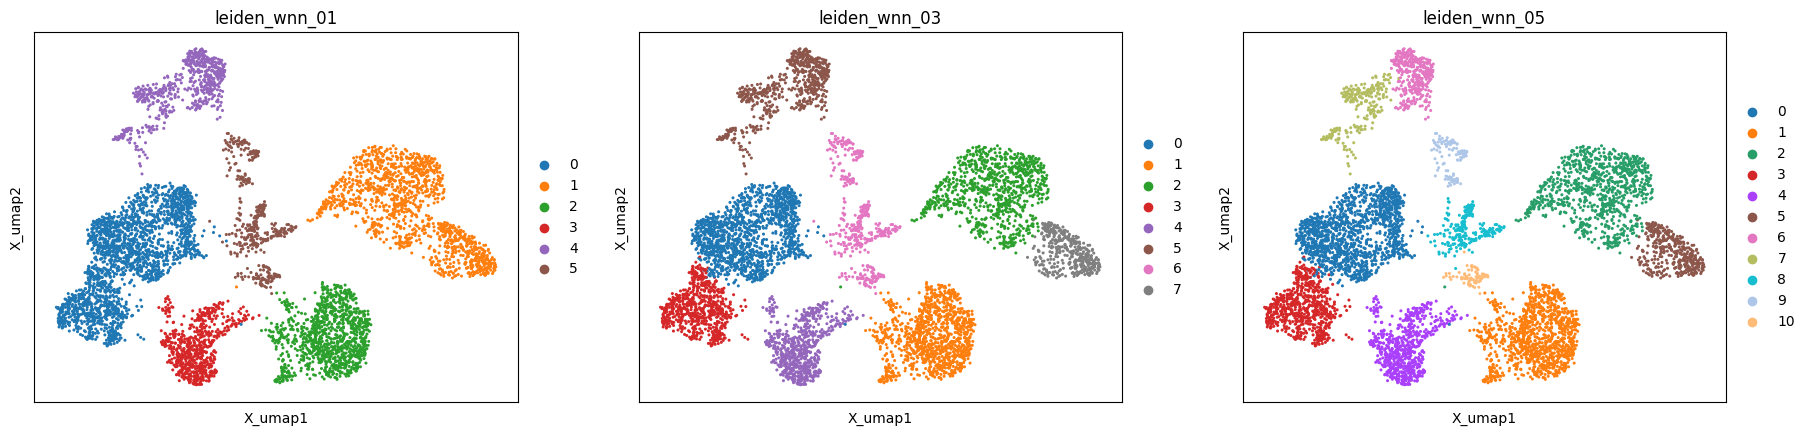

In [52]:
mu.pl.umap(mdata, color=["leiden_wnn_01","leiden_wnn_03","leiden_wnn_05"])

In [53]:
adata.obsm["X_umap_WNN_muon"] = mdata.obsm["X_umap"].copy()

In [54]:
adata.write_h5ad("/mnt/ibm_lg/yangjoon.kim/excellxgene_tutorial_manuscript/data/neurips2021_multiome/s1d1_rna_atac_joint_muon_wnn_v1.h5ad")

## Preprocess the ATAC dataset

- ATAC dataset has the format of cells x peaks. 
- We want to map the "peaks" to "genes" so that we can see the correlation between RNA and ATAC for different cell-types.
- In neurips 2021 (open problems), this task was done using Signac package. The resulting cell x gene count matrix (raw counts) is saved in adata.obsm["ATAC_gene_activity"], and the gene names are saved in adata.uns["ATAC_gene_activity_var_names"].
- 


In [26]:
adata_s1d1.uns["ATAC_gene_activity_var_names"]

array(['OR4F5', 'OR4F29', 'OR4F16', ..., 'DAZ4', 'BPY2C', 'CDY1'],
      dtype=object)

In [23]:
np.sum(adata_s1d1.obsm["ATAC_gene_activity"].todense(),1)
# the counts are "raw", not log-normalized just yet.

matrix([[4082.0847],
        [4981.3896],
        [4335.945 ],
        ...,
        [4387.2207],
        [3710.1345],
        [5052.951 ]], dtype=float32)

In [53]:
# subset the ATAC part of the object by creating a new anndata obje
adata_s1d1_ATAC = ad.AnnData(X = adata_s1d1.obsm["ATAC_gene_activity"],
                             obs = adata_s1d1.obs,
                             obsm = adata_s1d1.obsm)
adata_s1d1_ATAC.var_names = adata_s1d1.uns["ATAC_gene_activity_var_names"]
# save the raw counts
adata_s1d1_ATAC.layers["counts"] = adata_s1d1_ATAC.X.copy()
adata_s1d1_ATAC
# adata_s1d1_ATAC.X = adata_s1d1.obsm["ATAC_gene_activity"]

AnnData object with n_obs × n_vars = 6224 × 19039
    obs: 'GEX_pct_counts_mt', 'GEX_n_counts', 'GEX_n_genes', 'GEX_size_factors', 'GEX_phase', 'ATAC_nCount_peaks', 'ATAC_atac_fragments', 'ATAC_reads_in_peaks_frac', 'ATAC_blacklist_fraction', 'ATAC_nucleosome_signal', 'cell_type', 'batch', 'ATAC_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker'
    obsm: 'ATAC_gene_activity', 'ATAC_lsi_full', 'ATAC_lsi_red', 'ATAC_umap', 'GEX_X_pca', 'GEX_X_umap'
    layers: 'counts'

In [86]:
# log-normalize the counts in adata_s1d1_ATAC
sc.pp.normalize_total(adata_s1d1_ATAC, target_sum=1e4)
sc.pp.log1p(adata_s1d1_ATAC)

In [125]:
# subset the RNA part of the object (cell x gene(RNA))
adata_s1d1_RNA = adata_s1d1[:,adata_s1d1.var.feature_types=="GEX"]
adata_s1d1_RNA

View of AnnData object with n_obs × n_vars = 6224 × 13431
    obs: 'GEX_pct_counts_mt', 'GEX_n_counts', 'GEX_n_genes', 'GEX_size_factors', 'GEX_phase', 'ATAC_nCount_peaks', 'ATAC_atac_fragments', 'ATAC_reads_in_peaks_frac', 'ATAC_blacklist_fraction', 'ATAC_nucleosome_signal', 'cell_type', 'batch', 'ATAC_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker'
    var: 'feature_types', 'gene_id'
    uns: 'ATAC_gene_activity_var_names', 'dataset_id', 'genome', 'organism'
    obsm: 'ATAC_gene_activity', 'ATAC_lsi_full', 'ATAC_lsi_red', 'ATAC_umap', 'GEX_X_pca', 'GEX_X_umap'
    layers: 'counts'

## compute leiden clustering for each modality

- this functionality does not work in exCellxgene currently. (needs some debugging on what the exCellxgene grabs in the backend).

In [126]:
# need to specify which PCA, and keys to be used
sc.pp.neighbors(adata_s1d1_RNA, n_neighbors=10, n_pcs=40, use_rep="GEX_X_pca", key_added="GEX")

In [76]:
adata_s1d1_RNA

AnnData object with n_obs × n_vars = 6224 × 17813
    obs: 'GEX_pct_counts_mt', 'GEX_n_counts', 'GEX_n_genes', 'GEX_size_factors', 'GEX_phase', 'ATAC_nCount_peaks', 'ATAC_atac_fragments', 'ATAC_reads_in_peaks_frac', 'ATAC_blacklist_fraction', 'ATAC_nucleosome_signal', 'cell_type', 'batch', 'ATAC_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker'
    var: 'feature_types', 'gene_id'
    uns: 'ATAC_gene_activity_var_names', 'dataset_id', 'genome', 'organism', 'GEX'
    obsm: 'ATAC_gene_activity', 'ATAC_lsi_full', 'ATAC_lsi_red', 'ATAC_umap', 'GEX_X_pca', 'GEX_X_umap'
    layers: 'counts'
    obsp: 'GEX_distances', 'GEX_connectivities'

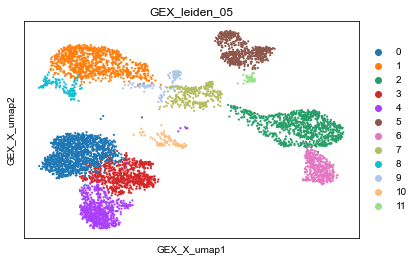

In [130]:
# compute the leiden clustering
sc.tl.leiden(adata_s1d1_RNA, key_added="GEX_leiden_05", neighbors_key="GEX", resolution=0.5)
sc.pl.embedding(adata_s1d1_RNA, basis="GEX_X_umap", color="GEX_leiden_05")

In [131]:
sc.tl.leiden(adata_s1d1_RNA, key_added="GEX_leiden_03", neighbors_key="GEX", resolution=0.3)
sc.tl.leiden(adata_s1d1_RNA, key_added="GEX_leiden_04", neighbors_key="GEX", resolution=0.4)
sc.tl.leiden(adata_s1d1_RNA, key_added="GEX_leiden_06", neighbors_key="GEX", resolution=0.6)

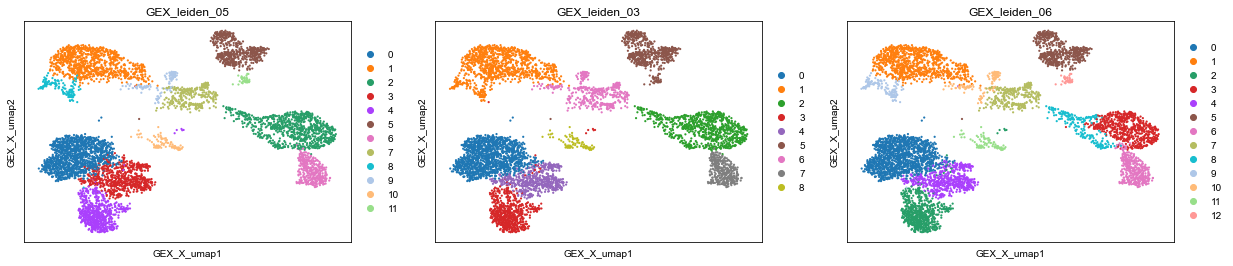

In [132]:
sc.pl.embedding(adata_s1d1_RNA, basis="GEX_X_umap", 
                color=["GEX_leiden_05", "GEX_leiden_03","GEX_leiden_06"])

### ATAC

In [87]:
adata_s1d1_ATAC

AnnData object with n_obs × n_vars = 6224 × 19039
    obs: 'GEX_pct_counts_mt', 'GEX_n_counts', 'GEX_n_genes', 'GEX_size_factors', 'GEX_phase', 'ATAC_nCount_peaks', 'ATAC_atac_fragments', 'ATAC_reads_in_peaks_frac', 'ATAC_blacklist_fraction', 'ATAC_nucleosome_signal', 'cell_type', 'batch', 'ATAC_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker'
    uns: 'log1p'
    obsm: 'ATAC_gene_activity', 'ATAC_lsi_full', 'ATAC_lsi_red', 'ATAC_umap', 'GEX_X_pca', 'GEX_X_umap'
    layers: 'counts'

In [88]:
# need to specify which PCA, and keys to be used
sc.pp.neighbors(adata_s1d1_ATAC, n_neighbors=10, n_pcs=40, use_rep="ATAC_lsi_full", key_added="ATAC")

In [113]:
# define the Dark2 color palette
# dark2 = plt.get_cmap('Dark2').colors
dark2 = ['#1b9e77', '#d95f02', '#7570b3', '#e7298a', '#66a61e', '#e6ab02', '#a6761d', '#666666']

# add new colors to the palette
new_colors = ['#A95C68', '#587B7F', '#8B6D9C']
dark2_extended = dark2 + new_colors

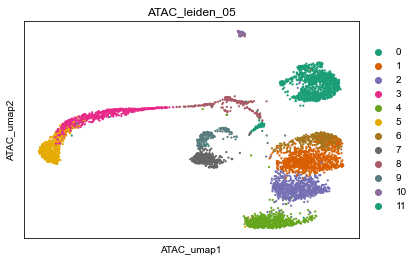

In [115]:
# compute the leiden clustering
sc.tl.leiden(adata_s1d1_ATAC, key_added="ATAC_leiden_05", neighbors_key="ATAC", resolution = 0.5)
sc.pl.embedding(adata_s1d1_ATAC, basis="ATAC_umap", color="ATAC_leiden_05", palette=dark2_extended) 

In [92]:
adata_s1d1_ATAC

AnnData object with n_obs × n_vars = 6224 × 19039
    obs: 'GEX_pct_counts_mt', 'GEX_n_counts', 'GEX_n_genes', 'GEX_size_factors', 'GEX_phase', 'ATAC_nCount_peaks', 'ATAC_atac_fragments', 'ATAC_reads_in_peaks_frac', 'ATAC_blacklist_fraction', 'ATAC_nucleosome_signal', 'cell_type', 'batch', 'ATAC_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'ATAC_leiden'
    uns: 'log1p', 'ATAC', 'leiden'
    obsm: 'ATAC_gene_activity', 'ATAC_lsi_full', 'ATAC_lsi_red', 'ATAC_umap', 'GEX_X_pca', 'GEX_X_umap'
    layers: 'counts'
    obsp: 'ATAC_distances', 'ATAC_connectivities'

In [163]:
['#1f77b4', '#ff7f0e', '#279e68', '#d62728', 
 '#aa40fc', '#8c564b', '#e377c2', '#b5bd61', 
 '#17becf', '#aec7e8', '#ffbb78', '#98df8a', '#ff9896']

OverloadedDict, wrapping:
	{'ATAC_gene_activity_var_names': array(['OR4F5', 'OR4F29', 'OR4F16', ..., 'DAZ4', 'BPY2C', 'CDY1'],
      dtype=object), 'dataset_id': 'openproblems_bmmc_multiome', 'genome': 'GRCh38', 'organism': 'human', 'GEX': {'connectivities_key': 'GEX_connectivities', 'distances_key': 'GEX_distances', 'params': {'n_neighbors': 10, 'method': 'umap', 'random_state': 0, 'metric': 'euclidean', 'use_rep': 'GEX_X_pca', 'n_pcs': 40}}, 'leiden': {'params': {'resolution': 0.6, 'random_state': 0, 'n_iterations': -1}}, 'GEX_leiden_05_colors': ['#1f77b4', '#ff7f0e', '#279e68', '#d62728', '#aa40fc', '#8c564b', '#e377c2', '#b5bd61', '#17becf', '#aec7e8', '#ffbb78', '#98df8a', '#ff9896'], 'GEX_leiden_03_colors': ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22'], 'GEX_leiden_06_colors': ['#1f77b4', '#ff7f0e', '#279e68', '#d62728', '#aa40fc', '#8c564b', '#e377c2', '#b5bd61', '#17becf', '#aec7e8', '#ffbb78', '#98df8a', '#ff9896']}
With ov

In [169]:
pip install pySankey==0.0.1


[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [170]:
from pysankey import sankey

# define the colors as the Set1 as the RNA clusters
colors = {
    "0": "#1f77b4",
    "1": "#ff7f0e",
    "2": "#279e68",
    "3": "#d62728",
    "4": "#aa40fc",
    "5": '#8c564b',
    "6": '#e377c2',
    "7": '#b5bd61',
    "8": '#17becf',
    "9": "#aec7e8",
    "10": "#ffbb78",
    "11":"#98df8a",
    "12":"#ff9896"
}


sankey(adata_joint.obs["GEX_leiden_05"], adata_joint.obs["ATAC_leiden_05"], aspect=20, colorDict=colors, fontsize=12)
# plt.savefig("GEX_ADT_leiden_sankey.pdf", dpi=300)

ModuleNotFoundError: No module named 'pysankey'

# Seurat v4 WNN

Updated: 3/22/2023



In [63]:
adata_seurat = sc.read("/mnt/ibm_lg/yangjoon.kim/excellxgene_tutorial_manuscript/data/neurips2021_multiome/s1d1_rna_atac_wnn_seurat.h5ad")
adata_seurat

AnnData object with n_obs × n_vars = 6224 × 124476
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'nCount_ATAC', 'nFeature_ATAC', 'nCount_SCT', 'nFeature_SCT', 'SCT.weight', 'ATAC.weight', 'wsnn_res.0.8', 'seurat_clusters', 'X', 'n_genes_by_counts', 'pct_counts_mt', 'n_counts', 'n_genes', 'size_factors', 'phase', 'leiden_final', 'atac_ann', 'cell_type', 'nCount_peaks', 'atac_fragments', 'reads_in_peaks_frac', 'blacklist_fraction', 'nucleosome_signal', 'rna_ann', 'cell_type_RNA', 'cell_type_ATAC', 'GEX_leiden_015', 'ATAC_leiden_015', 'manual_annotation_fine', 'manual_annotation_coarse', 'joint_leiden_015', 'joint_leiden_05'
    var: 'count', 'percentile'
    obsm: 'X_lsi', 'X_umap.atac', 'X_umap.rna', 'X_wnn.umap'
    varm: 'LSI'

In [12]:
adata.obs_names = adata.obs_names.str.replace("-s1d1","")
adata.obs_names

Index(['TAGTTGTCACCCTCAC-1', 'CTATGGCCATAACGGG-1', 'CCGCACACAGGTTAAA-1',
       'TCATTTGGTAATGGAA-1', 'ACCACATAGGTGTCCA-1', 'TGGATTGGTTTGCGAA-1',
       'GTGAGCGAGTAAAGGT-1', 'GACTTAGGTTGCGCGA-1', 'GCCTTACTCGTTACAA-1',
       'GTAAGGTCAATAACCT-1',
       ...
       'TTTCAGTTCTTAGCCC-1', 'GCAGCCAGTTTCAGGA-1', 'TTTAACGAGCGAGGTG-1',
       'GCGTAACGTTAAGCCA-1', 'CGGACAACAGCAACCT-1', 'AGACCCGGTTATCCTA-1',
       'GACCTAAGTGCCTCAC-1', 'AGCTCATAGCTATATG-1', 'TACGTACAGGAAACTG-1',
       'GGTTTCTGTTTATCTG-1'],
      dtype='object', length=6224)

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial


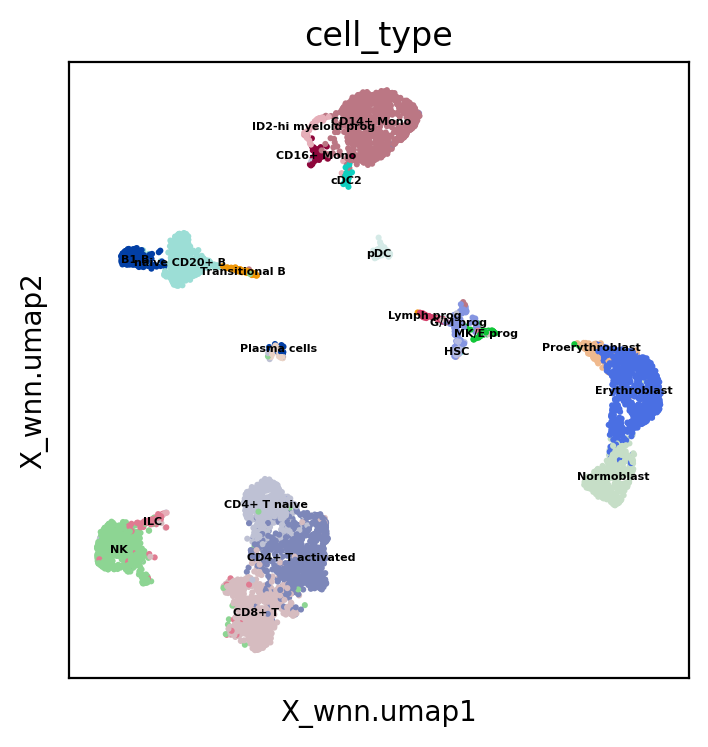

In [66]:
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams.update(mpl.rcParamsDefault) #Reset rcParams to default

with plt.rc_context({"figure.figsize": (4, 4), "figure.dpi": (200)}):
    sc.pl.embedding(adata_seurat, 
                basis="X_wnn.umap", color="cell_type", legend_loc="on data", legend_fontsize=4)

In [58]:
# adata.obsm["X_umap_WNN_seurat"] = adata_seurat.obsm["X_wnn.umap"]

In [68]:
# bring in the cell x genes (RNA+ATAC-mapped) format again

adata_test = sc.read_h5ad("/mnt/ibm_lg/yangjoon.kim/excellxgene_tutorial_manuscript/data/neurips2021_multiome/s1d1_rna_atac_joint_v3.h5ad")
adata_test

AnnData object with n_obs × n_vars = 6224 × 36852
    obs: 'n_genes_by_counts', 'pct_counts_mt', 'n_counts', 'n_genes', 'size_factors', 'phase', 'leiden_final', 'atac_ann', 'cell_type', 'nCount_peaks', 'atac_fragments', 'reads_in_peaks_frac', 'blacklist_fraction', 'nucleosome_signal', 'rna_ann', 'cell_type_RNA', 'cell_type_ATAC', 'GEX_leiden_015', 'ATAC_leiden_015', 'manual_annotation_fine', 'manual_annotation_coarse', 'joint_leiden_015', 'joint_leiden_05'
    var: 'assay'
    uns: 'ATAC_leiden_015_colors', 'GEX_leiden_015_colors', 'cell_type_colors', 'joint_leiden_015_colors', 'joint_leiden_05_colors', 'leiden', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_pca_RNA', 'X_umap', 'X_umap_ATAC', 'X_umap_RNA'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [69]:
adata_test.obsm["X_umap_WNN_muon"] = adata.obsm["X_umap_WNN_muon"]
adata_test.obsm["X_umap_WNN_seurat"] = adata_seurat.obsm["X_wnn.umap"]

In [70]:
adata_test.write_h5ad("/mnt/ibm_lg/yangjoon.kim/excellxgene_tutorial_manuscript/data/neurips2021_multiome/s1d1_rna_atac_joint_v4.h5ad")

In [59]:
# adata.write_h5ad("/mnt/ibm_lg/yangjoon.kim/excellxgene_tutorial_manuscript/data/neurips2021_multiome/s1d1_rna_atac_joint_muon_seurat_wnn_v1.h5ad")